In [1]:
from google.colab import drive

drive.mount('/content/drive')
file_path = "/content/drive/My Drive/Ain Shams Uni/Computer Vision/Computer Vision.zip"

Mounted at /content/drive


In [2]:
import zipfile
import os

extract_path = "/content/Computer_Vision"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction Complete! Files are in:", extract_path)

Extraction Complete! Files are in: /content/Computer_Vision


In [3]:
train_data_path = '/content/Computer_Vision/Computer Vision/Train Images 13440x32x32/train'
test_data_path = '/content/Computer_Vision/Computer Vision/Test Images 3360x32x32/test'

print("Contents of Train Directory:", os.listdir(train_data_path))
print("Contents of Test Directory:", os.listdir(test_data_path))

Contents of Train Directory: ['id_2936_label_3.png', 'id_12787_label_3.png', 'id_325_label_13.png', 'id_12178_label_11.png', 'id_1794_label_1.png', 'id_12184_label_11.png', 'id_3956_label_19.png', 'id_9231_label_6.png', 'id_2127_label_14.png', 'id_11383_label_23.png', 'id_10933_label_23.png', 'id_7718_label_13.png', 'id_6663_label_21.png', 'id_11606_label_23.png', 'id_8465_label_23.png', 'id_12439_label_15.png', 'id_12238_label_18.png', 'id_3510_label_19.png', 'id_6859_label_18.png', 'id_13040_label_6.png', 'id_7690_label_10.png', 'id_2819_label_17.png', 'id_6791_label_9.png', 'id_971_label_10.png', 'id_5189_label_5.png', 'id_10530_label_1.png', 'id_6929_label_27.png', 'id_5057_label_17.png', 'id_2022_label_1.png', 'id_9768_label_17.png', 'id_9640_label_1.png', 'id_5628_label_4.png', 'id_4954_label_4.png', 'id_5714_label_15.png', 'id_1372_label_4.png', 'id_10323_label_3.png', 'id_929_label_5.png', 'id_7772_label_20.png', 'id_2955_label_6.png', 'id_2093_label_10.png', 'id_6738_label_3.p

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import re


# Custom dataset class
class ArabicLetterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.png')]  # Adjust extension if needed

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_name = self.files[index]

        # Extract label from filename (e.g., "id_2936_label_3.png" → label = 3)
        match = re.search(r'label_(\d+)', img_name)
        label = int(match.group(1)) - 1 if match else -1  # Default to -1 if no match

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

train_dataset = ArabicLetterDataset(root_dir=train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ArabicLetterDataset(root_dir=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Check content
batch_one = next(iter(train_loader))
images, labels = batch_one

print("Batch shape:", images.shape)
print("Sample labels:", labels)


Batch shape: torch.Size([32, 1, 32, 32])
Sample labels: tensor([ 4, 22,  9, 15,  0,  2, 14, 10, 22, 17, 25, 22, 21, 19, 21, 22, 11, 12,
        11, 19, 21, 21, 11, 14,  4, 23,  0, 12, 27,  0, 17, 11])


In [6]:
import torch.nn.functional as F
import torch.nn as nn

class ArabicLetterCNN(nn.Module):
    def __init__(self, num_classes=28):
        super(ArabicLetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1 * 32 * 32 -{After Padding}-> (32 * 16 * 16)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64 * 16 * 16 -{After Padding}-> (64 * 8 * 8)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = ArabicLetterCNN()


In [7]:
class EarlyStopping:

    def __init__(self, patience=3, min_delta=0.0):
        """
        Args:
            patience (int): Number of epochs to wait after the last improvement.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust learning rate every 5 epochs

# Early stopping instance
early_stopping = EarlyStopping(patience=2, min_delta=0.01)

# Gradient clipping value
max_grad_norm = 1.0

threshold = 0.005

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(train_loader)

    # Update learning rate
    scheduler.step()

    # Print epoch loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Early stopping check
    early_stopping(epoch_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1} with loss {epoch_loss}")
        break

    # Break if loss is below a certain threshold
    if epoch_loss < threshold:
        print(f"Loss is below the threshold. Stopping training at epoch {epoch+1}.")
        break

Epoch 1/10, Loss: 1.5566765442490578
Epoch 2/10, Loss: 0.6314631497576123
Epoch 3/10, Loss: 0.4028107809168952
Epoch 4/10, Loss: 0.2828179432167893
Epoch 5/10, Loss: 0.2055791265464255
Epoch 6/10, Loss: 0.08389295652131772
Epoch 7/10, Loss: 0.06107937389918204
Epoch 8/10, Loss: 0.05145238382198537
Epoch 9/10, Loss: 0.044069732178745435
Epoch 10/10, Loss: 0.03745569220710812


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 99.33%


In [10]:
# Load test images
test_images = [f for f in os.listdir(test_data_path) if f.endswith('.png')]  # Adjust extension if needed
print(f"Found {len(test_images)} test images.")

Found 3360 test images.


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 91.28%


In [12]:
import pandas as pd

predictions = []

with torch.no_grad():
    for img_name in test_images:
        img_path = os.path.join(test_data_path, img_name)
        image = Image.open(img_path).convert("L")
        image = transform(image).unsqueeze(0)

        output = model(image)
        predicted_class = int(torch.argmax(output, dim=1).item()) + 1

        predictions.append([img_name, predicted_class])

# Save as CSV
df = pd.DataFrame(predictions, columns=["Image", "Predicted_Label"])
df.to_csv("test_predictions.csv", index=False)

In [13]:
# Extract true labels from filenames (if applicable)
true_labels = []
predicted_labels = []

for img_name, predicted in predictions:
    match = re.search(r'label_(\d+)', img_name)
    if not match: continue

    true_label = int(match.group(1))
    true_labels.append(true_label)
    predicted_labels.append(predicted)

print("MAX samples labels:", max(true_labels))
print("MAX predicted labels samples:", max(predicted_labels))

MAX samples labels: 28
MAX predicted labels samples: 28


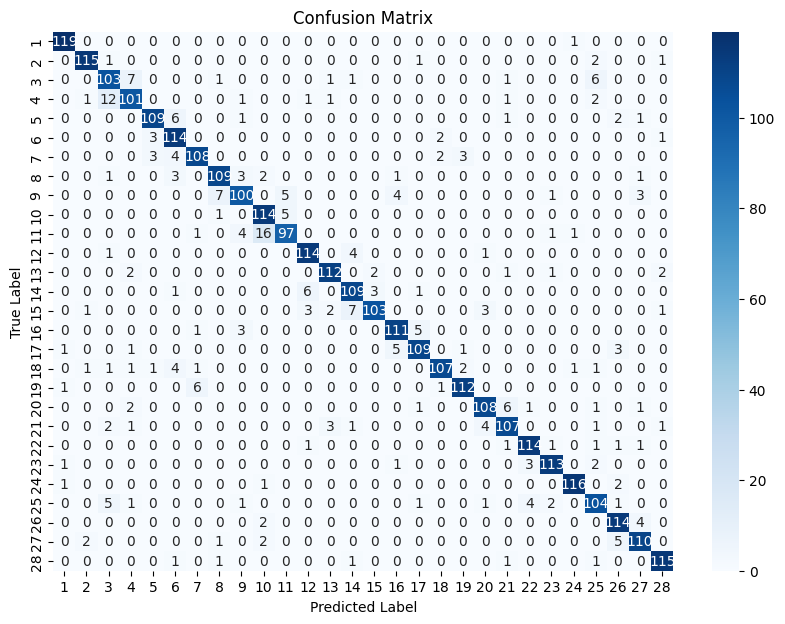

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 29), yticklabels=range(1, 29))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


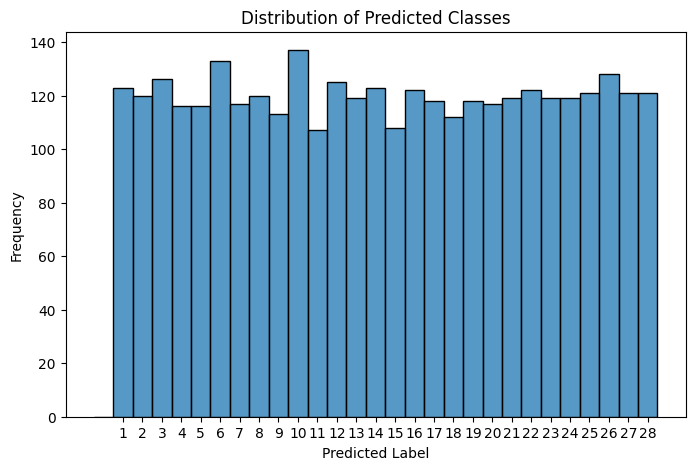

In [15]:
import numpy as np

plt.figure(figsize=(8, 5))
sns.histplot(predicted_labels, bins=np.arange(0, 30) - 0.5, kde=False)
plt.xticks(range(1, 29))
plt.xlabel("Predicted Label")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Classes")
plt.show()

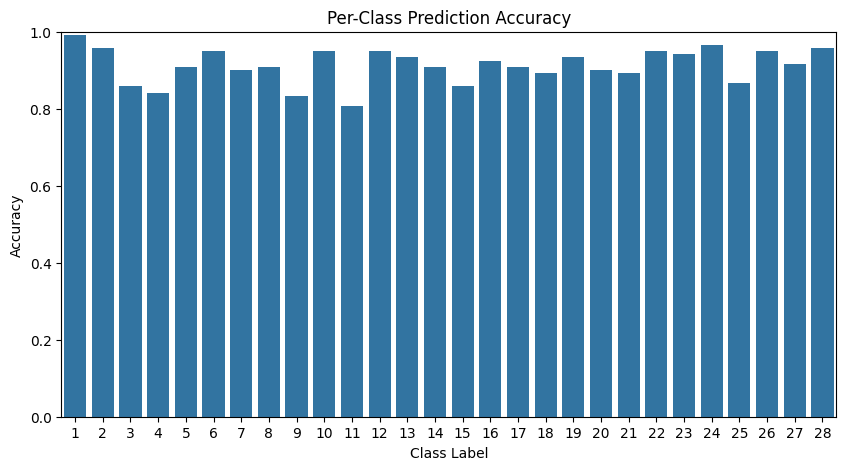

In [16]:
# Calculate per-class accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracies = np.nan_to_num(class_accuracies)  # Handle zero-division

# Plot per-class accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x=list(range(1, 29)), y=class_accuracies)
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.title("Per-Class Prediction Accuracy")
plt.ylim(0, 1)
plt.show()